In [79]:
import pickle
import cv2

import pandas as pd
from pandas import DataFrame

import torch
from torch import Tensor

from architecture import *

import matplotlib.pyplot as plt

import mediapipe as mp
import numpy as np

# Load Data

In [88]:
# Loading Model from pickle
with open('generated-data/model/model.pkl', 'rb') as file:
    model = pickle.load(file)

# Loading feature pipeline from pickle
with open('generated-data/preprocessed-data/feature_pipeline.pkl', 'rb') as file:
    feature_pipeline = pickle.load(file)

# Loading feature pipeline from pickle
with open('generated-data/preprocessed-data/label_pipeline.pkl', 'rb') as file:
    label_pipeline = pickle.load(file)

# Process Image

In [52]:
def draw_landmarks(image, landmarks, mp_hands, mp_drawing):
    """
    Auxillary function for process_image(). Creates a before and after picture showing hand landmarks drawn onto the original picture.
    """
    
    # Draw the landmarks on the image
    image_with_landmarks = image.copy()
    mp_drawing.draw_landmarks(
        image_with_landmarks,
        landmarks,
        mp_hands.HAND_CONNECTIONS)

    # Display the original image and the image with the detected landmarks using a plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(image_with_landmarks, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Image with Landmarks')
    axs[1].axis('off')
    plt.show()

In [53]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

def process_image(image_path, show=False, label=True):
    """
    This function takes in an image, applies the MediaPipe hand model, and stores the landmark x, y, and z positions
    in a list.

    Output list is in the form of all the X coordinates followed by Y and Z [x0, ... ,x20, y0, ... , y20, z0, ... , z20].

    Parameters:
    image_path (str): The path to the image file.
    show (bool): If true, displays the image before and after the MediaPipe model is applied.
    label (bool): If true, output list will be followed up by the label associated with image and the image path.

    Returns:
    list: A list containing the landmark x, y, and z positions.
    """

    # Load the image
    image = cv2.imread(image_path)


    # Initialize the Hands class from the MediaPipe library with a minimum detection confidence and tracking confidence
    with mp_hands.Hands(
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as hands:

        # Convert the image from BGR (OpenCV's default color format) to RGB (MediaPipe's required color format)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image using the Hands class to detect and track the hand
        results = hands.process(image_rgb)

        # If any hands are detected, extract the landmarks and draw them on the image
        if results.multi_hand_landmarks:
            landmarks = results.multi_hand_landmarks[0]

            # Create a list to store the landmark positions
            landmark_positions = []

            # Iterate over the landmarks and append their x, y, and z positions to the list
            for landmark in landmarks.landmark:
                landmark_positions.append([landmark.x, landmark.y, landmark.z])

            # Flattening Data
            landmark_positions = [*np.array(landmark_positions).T.flatten()]

            # Adds a label to for the entry based off of the file it is located in. Also Shows full path.
            if label:
                landmark_positions += [image_path.split("/")[-2]]
                landmark_positions += [image_path]

            # Shows before and after picture showing hand landmarks drawn onto the original picture.
            if show:
                draw_landmarks(image, landmarks, mp_hands, mp_drawing)

            # Converting df into dict

            return landmark_positions

        else:
            # print("\nNo hands detected in the image.")
            raise Exception("No hands detected in the image.")
            pass

I0000 00:00:1726773623.016982   12546 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1726773623.018110   13912 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: AMD Radeon RX 6700 XT (navi22, LLVM 15.0.7, DRM 3.57, 6.8.0-40-generic)


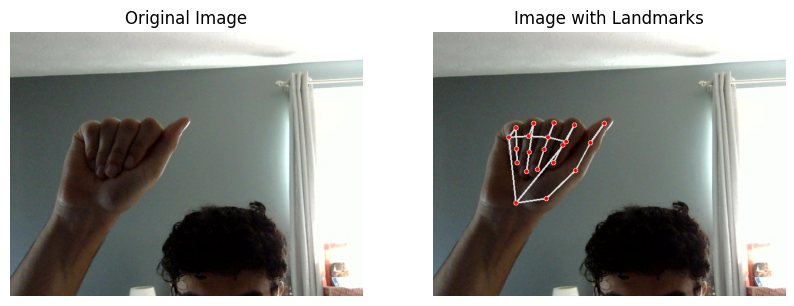

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20
0,0.235747,0.320665,0.40336,0.446559,0.485213,0.377002,0.400764,0.368133,0.340923,0.325246,...,-0.050852,-0.044616,0.00409,-0.042087,-0.036856,-0.017565,0.001969,-0.032057,-0.026989,-0.011446


In [74]:
landmark_data = DataFrame(process_image('captured_image.jpg', show=True, label=False)).T
landmark_data.columns = [f'x{x}' for x in range(21)] + [f'y{x}' for x in range(21)] + [f'z{x}' for x in range(21)]
landmark_data.head()

In [76]:
scaled_data = feature_pipeline.transform(landmark_data)
scaled_data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20
0,0.205552,0.261536,0.331839,0.402123,0.437309,0.364405,0.383051,0.349043,0.350717,0.320075,...,0.734465,0.775244,0.818259,0.754665,0.784488,0.818393,0.744111,0.708257,0.730142,0.76738


In [92]:
prediction = np.argmax(nn.Softmax(1)(model(Tensor(scaled_data.values))).detach().numpy())
prediction

0

In [99]:
label_pipeline.inverse_transform(DataFrame([[prediction]])).values[0][0]

'A'